Notebook d’éval qui :

	•	Évalue sur test

	•	Donne loss / acc / F1

	•	Trace ROC + AUC

	•	Trace matrice de confusion

	•	Affiche contact / GT / prédiction / proba
	
	•	Montre courbes train/val (loss & F1)

In [86]:
# import chemin 

from pathlib import Path
import sys
import random

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd  # pour lire le training_log

# Chemins projet
ROOT = Path("..").resolve()
SRC_DIR = ROOT / "src"
sys.path.append(str(SRC_DIR))

from models.unet import UNet2D
from training.dataset import ContactDomainDataset

ML_UNET_ROOT = ROOT / "kopis_data" / "ml" / "unet"
SPLITS_DIR = ML_UNET_ROOT / "splits"
RESULTS_ROOT = ROOT / "results" / "unet"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [87]:
#Charger les IDs du split test et le dataloader

def load_ids(path: Path):
    return [l.strip() for l in path.read_text().splitlines() if l.strip()]

test_file = SPLITS_DIR / "test_ids.txt"
if not test_file.exists():
    raise FileNotFoundError(f"{test_file} introuvable. Lance d'abord train_unet.py pour créer les splits.")

test_ids = load_ids(test_file)
len(test_ids), test_ids[:5]

(210, ['A6T926', 'G0SET4', 'O00585', 'B2JLJ0', 'A0A0H2URR1'])

In [88]:
# Dataset & DataLoader test
test_dataset = ContactDomainDataset(test_ids)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # N variable -> batch_size=1
    shuffle=False,
    num_workers=0,
)
len(test_dataset)

210

In [89]:
#charher le meilleur modele
best_model_path = RESULTS_ROOT / "best_model.pt"
if not best_model_path.exists():
    raise FileNotFoundError(f"{best_model_path} introuvable. As-tu bien lancé train_unet.py ?")

checkpoint = torch.load(best_model_path, map_location=DEVICE)

model = UNet2D(in_channels=1, out_channels=1, base_channels=32).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_loss'])

In [90]:
#Fonctions de métriques (les mêmes qu’en train)
def compute_batch_metrics(logits: torch.Tensor, targets: torch.Tensor):
    """
    logits : [B, 1, N, N]
    targets : [B, 1, N, N] (0/1)
    """
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true = targets.view(-1)
        y_pred = preds.view(-1)

        tp = (y_true * y_pred).sum().item()
        fp = ((1 - y_true) * y_pred).sum().item()
        fn = (y_true * (1 - y_pred)).sum().item()
        tn = ((1 - y_true) * (1 - y_pred)).sum().item()

        acc = (tp + tn) / max(tp + tn + fp + fn, 1.0)
        precision = tp / max(tp + fp, 1.0)
        recall = tp / max(tp + fn, 1.0)

        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

    return acc, f1

In [91]:
# evaluation globale sur le set test
criterion = torch.nn.BCEWithLogitsLoss()

model.eval()
total_loss = 0.0
total_acc = 0.0
total_f1 = 0.0
n_batches = 0

all_probs = []
all_targets = []

with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        logits = model(X)
        loss = criterion(logits, Y)

        acc, f1 = compute_batch_metrics(logits, Y)

        total_loss += loss.item()
        total_acc += acc
        total_f1 += f1
        n_batches += 1

        # pour ROC / matrice de confusion
        probs = torch.sigmoid(logits).view(-1).cpu().numpy()
        targets = Y.view(-1).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(targets)

# concaténer tout
all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)

test_loss = total_loss / n_batches
test_acc = total_acc / n_batches
test_f1 = total_f1 / n_batches

test_loss, test_acc, test_f1

(0.18625976336853844, 0.9214073512224176, 0.774426371118908)

In [92]:
# Recherche d'un seuil optimal sur la F1 (ici sur le test, idéalement sur la val)
thresholds = np.linspace(0.1, 0.9, 17)  # 0.10, 0.15, ..., 0.90
best_thr = 0.5
best_f1 = 0.0

y_true_flat = all_targets.astype(int)

for thr in thresholds:
    y_pred_flat = (all_probs > thr).astype(int)

    tp = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1 = 0 if prec + rec == 0 else 2 * prec * rec / (prec + rec)

    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Seuil optimal :", best_thr, "F1 =", best_f1)

Seuil optimal : 0.30000000000000004 F1 = 0.7215959357009493


/var/folders/33/v346dd8n2yx91hdptg2l0y3h0000gn/T/ipykernel_21854/3488232936.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/l1-python/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


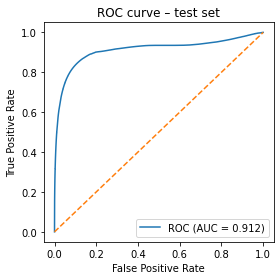

In [93]:
# roc curve + auc 
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – test set")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:


# matrice de confusion seuillée à 0.5
y_pred_bin = (all_probs > best_thr).astype(int)
cm = confusion_matrix(all_targets, y_pred_bin)

cm

array([[22845873,   945851],
       [ 1039550,  2572982]])

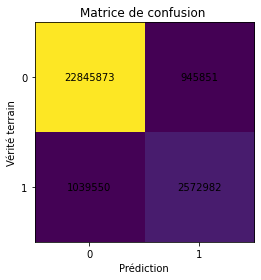

In [95]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_yticklabels(["0", "1"])
ax.set_xlabel("Prédiction")
ax.set_ylabel("Vérité terrain")
ax.set_title("Matrice de confusion ")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [96]:
# visualisation de quelques prédictions , proba , contact , gt
# choisir un ID au hasard dans le test set
prot_id = random.choice(test_ids)
prot_id

'O07427'

In [97]:
# Charger directement les fichiers .npy pour cet ID
contacts_path = ML_UNET_ROOT / "contacts" / f"{prot_id}.npy"
domains_path = ML_UNET_ROOT / "domains" / f"{prot_id}.npy"

contact = np.load(contacts_path)      # (N, N)
domain_map = np.load(domains_path)    # (N, N)

X = torch.from_numpy(contact).unsqueeze(0).unsqueeze(0).float().to(DEVICE)  # [1,1,N,N]

model.eval()
with torch.no_grad():
    logits = model(X)
    probs = torch.sigmoid(logits)[0, 0].cpu().numpy()
    pred_binary = (probs > best_thr).astype(np.float32)

contact.shape, domain_map.shape, probs.shape

((279, 279), (279, 279), (279, 279))

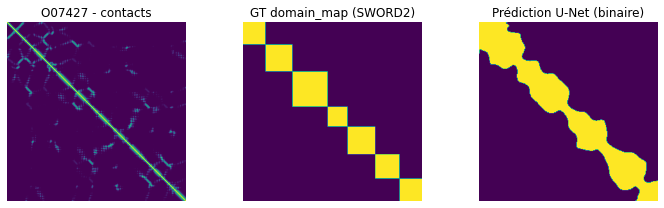

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].imshow(contact)
axes[0].set_title(f"{prot_id} - contacts")

axes[1].imshow(domain_map)
axes[1].set_title("GT domain_map (SWORD2)")

axes[2].imshow(pred_binary)
axes[2].set_title("Prédiction U-Net (binaire)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

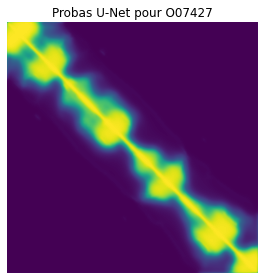

In [99]:
plt.figure(figsize=(4, 4))
plt.imshow(probs)
plt.title(f"Probas U-Net pour {prot_id}")
plt.axis("off")
plt.tight_layout()
plt.show()

In [100]:
# courbe de loss / f1 train vs val 
log_path = RESULTS_ROOT / "training_log.csv"
df = pd.read_csv(log_path)


df = df[df["train_acc"] > 0].reset_index(drop=True)


df = df.tail(5).reset_index(drop=True)

# pour avoir un axe propre 1..5
df["epoch_run"] = np.arange(1, len(df) + 1)

df

,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1,epoch_run
0,1,0.503295,0.907143,0.742069,0.443823,0.896634,0.763963,1
1,2,0.371123,0.916464,0.764962,0.402320,0.898129,0.684729,2
2,3,0.347128,0.918571,0.767246,0.348348,0.912596,0.771639,3
3,4,0.328848,0.921874,0.778278,0.387839,0.896987,0.770192,4
4,5,0.318794,0.923888,0.783407,0.345788,0.909990,0.780688,5


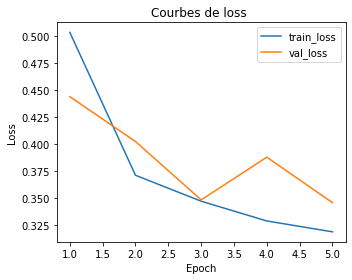

In [101]:
plt.figure(figsize=(5, 4))
plt.plot(df["epoch_run"], df["train_loss"], label="train_loss")
plt.plot(df["epoch_run"], df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbes de loss ")
plt.legend()
plt.tight_layout()
plt.show()

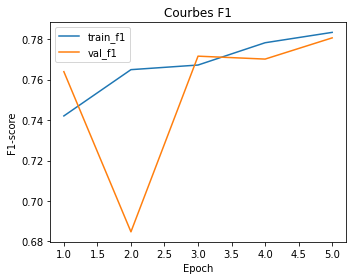

In [102]:
plt.figure(figsize=(5, 4))
plt.plot(df["epoch_run"], df["train_f1"], label="train_f1")
plt.plot(df["epoch_run"], df["val_f1"], label="val_f1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Courbes F1")
plt.legend()
plt.tight_layout()
plt.show()